# \begin{equation*} \frac{D \sigma}{D t} = \dot\sigma_{\theta} = \frac{\partial \sigma_{\theta}}{\partial \theta} \dot\theta + \frac{\partial \sigma_{\theta}}{\partial S} \dot S \end{equation*}
## **SOSE**

In [1]:
from dask_gateway import Gateway

g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1ae974e59b6542cd979bdcc3377f9f7d/status,


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
from fastjmd95 import jmd95numba
import fastjmd95
import dask.array as dsa
import json

In [4]:
#bringing in uploaded ds

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filename):
    path = "pangeo-tmp/stb2145/models/SOSE/"
    return xr.open_zarr(gcfs_w_token.get_mapper(path + filename), consolidated=False)

ds_slt = open_ds('budget_slt.zarr')
ds_temp = open_ds('budget_th.zarr')
coords_unrolled = open_ds('coords.zarr')
ds_tns = open_ds('ds_tns.zarr')
ds_vel = open_ds('ds_vel.zarr')
ds_empmr = open_ds('ds_SIempmr.zarr')

ds_unrolled = xr.merge([ds_tns, ds_slt, ds_temp, ds_vel, ds_empmr])

In [5]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
#WG model's boundaries (-77.87497˚S, -57.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #-77.87497
upper_lat = 125 #-57.041634
left_lon =  310 #51.75
right_lon = 880 #146.75

#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))
lat_range_u = dict(YG=slice(lower_lat, upper_lat+1))
lon_range_u = dict(XG=slice(left_lon, right_lon+1))

coords = coords_unrolled.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)
ds = ds_unrolled.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)

In [6]:
pref = 2000

# <font color='Green'> \begin{equation*} Temperature \end{equation*} </font>

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial \theta}\end{equation*} </font>

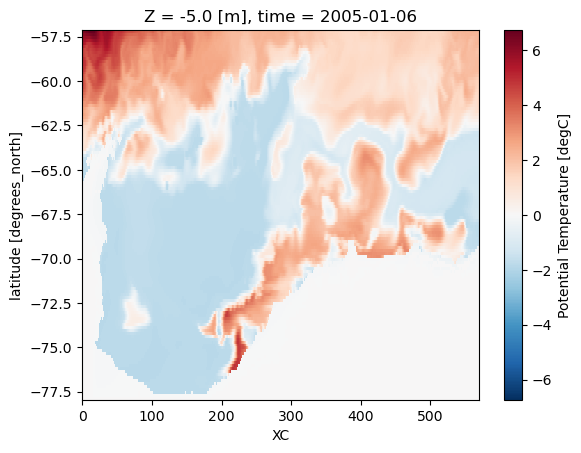

In [7]:
ds.THETA[0,0].drop('XC').plot()

In [8]:
drhodt = fastjmd95.drhodt(ds.SALT, ds.THETA, pref)
drhodt

,Array,Chunk
Bytes,9.77 GiB,22.83 MiB
Shape,"(438, 42, 125, 570)","(1, 42, 125, 570)"
Count,18 Graph Layers,438 Chunks
Type,float64,numpy.ndarray


## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial \theta} \dot \theta \end{equation*} </font>

In [9]:
ds_tmp_wg = ds_temp.roll(XC=700, roll_coords=True).isel(**lat_range, **lon_range)

In [10]:
ds_sig_theta = (drhodt * ds_tmp_wg)#.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'time':1})

In [11]:
ds_sig_theta

,Array,Chunk
Bytes,9.77 GiB,22.83 MiB
Shape,"(438, 42, 125, 570)","(1, 42, 125, 570)"
Count,26 Graph Layers,438 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,9.77 GiB,22.83 MiB
Shape,"(438, 42, 125, 570)","(1, 42, 125, 570)"
Count,26 Graph Layers,438 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [12]:
rhs_theta = (ds_sig_theta.conv_horiz_adv_flux_TH+ 
              ds_sig_theta.conv_horiz_diff_flux_TH + 
              ds_sig_theta.conv_vert_adv_flux_TH +
              ds_sig_theta.conv_vert_diff_flux_TH + 
              ds_sig_theta.surface_flux_conv_TH + 
              ds_sig_theta.sw_flux_conv_TH)#.load()

lhs_theta = ds_sig_theta.total_tendency_TH_truth#.load()

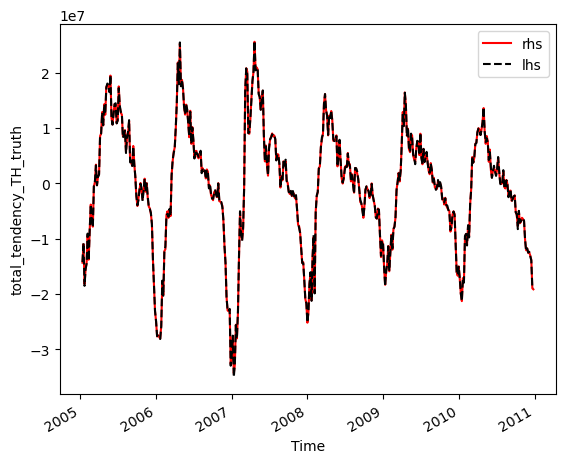

In [13]:
#checking equality
rhs_theta[1:-1].sum(['XC', 'YC', 'Z']).plot(label='rhs', color='r')
lhs_theta[1:-1].sum(['XC', 'YC', 'Z']).plot(label='lhs', color='k', linestyle='--')
plt.legend();

In [14]:
(rhs_theta-lhs_theta).sum(['XC', 'YC', 'Z']).mean('time').values / 1e6 

-0.0006483551118699844

In [15]:
rhs_vars = [dvar for dvar in ds_sig_theta.data_vars
            if dvar != 'total_tendency_TH_truth']
total_tendency_check = sum([ds_sig_theta[dvar] for dvar in rhs_vars])
total_tendency_check

,Array,Chunk
Bytes,9.77 GiB,22.83 MiB
Shape,"(438, 42, 125, 570)","(1, 42, 125, 570)"
Count,82 Graph Layers,438 Chunks
Type,float64,numpy.ndarray


In [16]:
mask = coords.hFacC[0] > 0

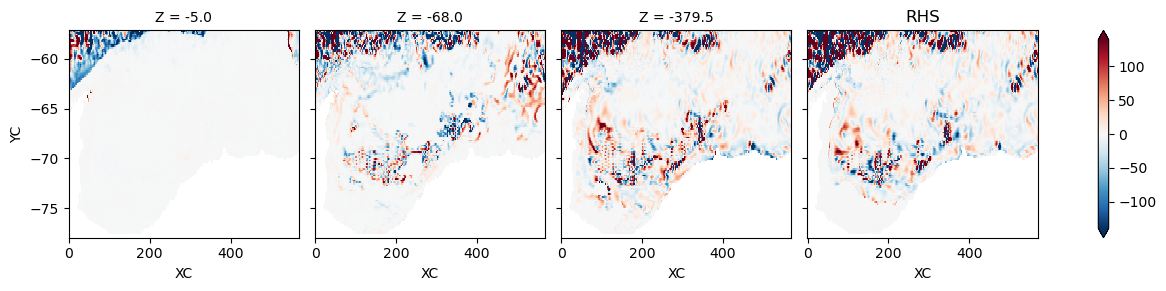

In [17]:
total_tendency_check.isel(time=200, Z=[0, 5, 15, 20]).where(mask).drop('XC').plot(robust=True, col='Z')
plt.title('RHS');

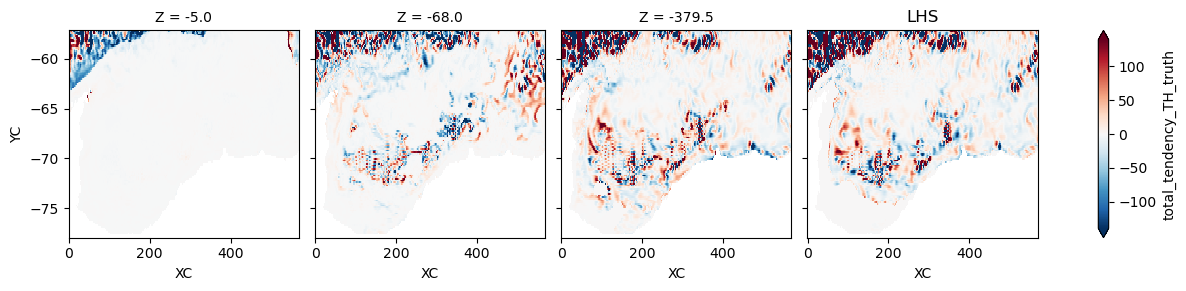

In [18]:
ds_sig_theta.total_tendency_TH_truth.isel(time=200, Z=[0, 5, 15, 20]).where(mask).drop('XC').plot(robust=True, col='Z')
plt.title('LHS');

# <font color='Green'> \begin{equation*} Salinity \end{equation*} </font>

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial S} \end{equation*} </font>

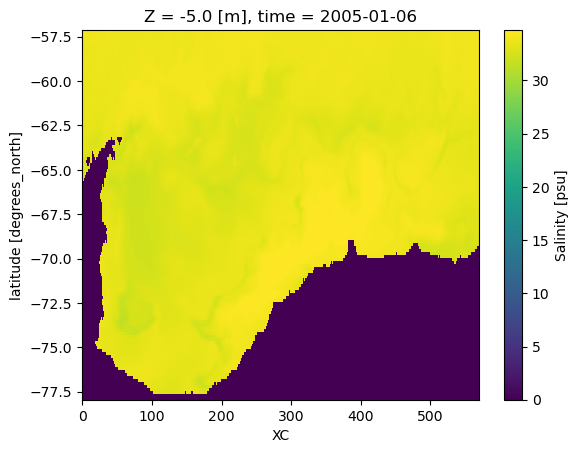

In [19]:
ds.SALT[0,0].drop('XC').plot()

In [20]:
drhods = fastjmd95.drhods(ds.SALT, ds.THETA, pref)
drhods

,Array,Chunk
Bytes,9.77 GiB,22.83 MiB
Shape,"(438, 42, 125, 570)","(1, 42, 125, 570)"
Count,18 Graph Layers,438 Chunks
Type,float64,numpy.ndarray


## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial S} \dot S \end{equation*} </font>

In [21]:
ds_slt_wg = ds_slt.roll(XC=700, roll_coords=True).isel(**lat_range, **lon_range)

In [22]:
ds_sig_salt = (drhods * ds_slt_wg)#.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'time':1})

In [23]:
ds_sig_salt

,Array,Chunk
Bytes,9.77 GiB,22.83 MiB
Shape,"(438, 42, 125, 570)","(1, 42, 125, 570)"
Count,26 Graph Layers,438 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,9.77 GiB,22.83 MiB
Shape,"(438, 42, 125, 570)","(1, 42, 125, 570)"
Count,26 Graph Layers,438 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [24]:
rhs_salt = (ds_sig_salt.conv_horiz_adv_flux_SLT + 
              ds_sig_salt.conv_horiz_diff_flux_SLT + 
              ds_sig_salt.conv_vert_adv_flux_SLT +
              ds_sig_salt.conv_vert_diff_flux_SLT + 
              ds_sig_salt.surface_flux_conv_SLT + 
              ds_sig_salt.lin_fs_correction_SLT)#.load()

lhs_salt = ds_sig_salt.total_tendency_SLT_truth#.load()

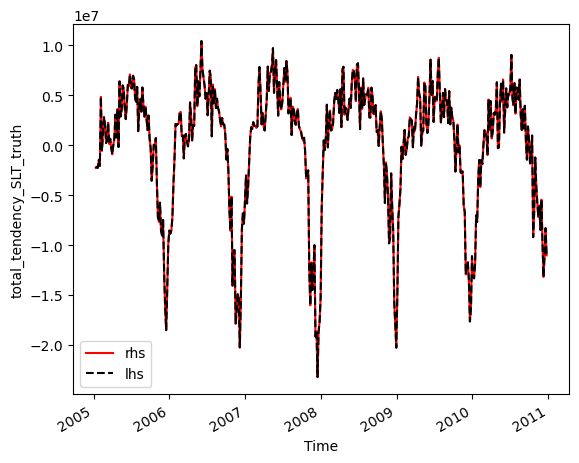

In [25]:
#checking equality
rhs_salt[1:-1].sum(['XC', 'YC', 'Z']).plot(label='rhs', color='r')
lhs_salt[1:-1].sum(['XC', 'YC', 'Z']).plot(label='lhs', color='k', linestyle='--')
plt.legend();

In [26]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1ae974e59b6542cd979bdcc3377f9f7d/status,


In [27]:
(rhs_salt-lhs_salt).sum(['XC', 'YC', 'Z']).mean('time').values / 1e6 

7.117040420278963e-07

In [28]:
rhs_vars = [dvar for dvar in ds_sig_salt.data_vars
            if dvar != 'total_tendency_TH_truth']
total_tendency_check = sum([ds_sig_salt[dvar] for dvar in rhs_vars])
total_tendency_check

,Array,Chunk
Bytes,9.77 GiB,22.83 MiB
Shape,"(438, 42, 125, 570)","(1, 42, 125, 570)"
Count,81 Graph Layers,438 Chunks
Type,float64,numpy.ndarray


In [29]:
mask = coords.hFacC[0] > 0

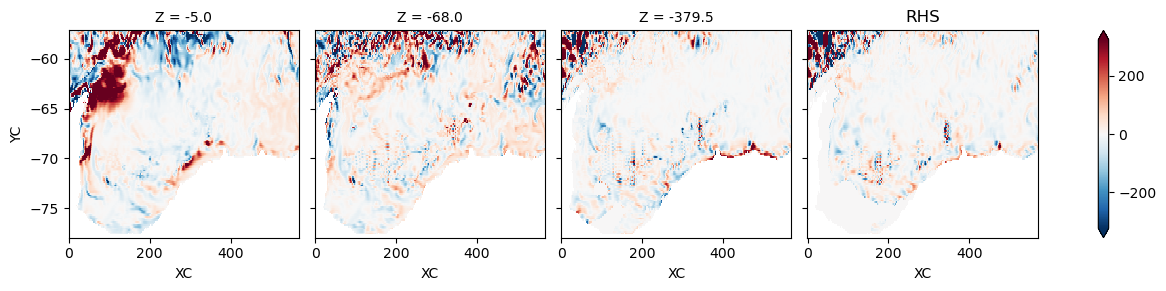

In [30]:
total_tendency_check.isel(time=200, Z=[0, 5, 15, 20]).where(mask).drop('XC').plot(robust=True, col='Z')
plt.title('RHS');

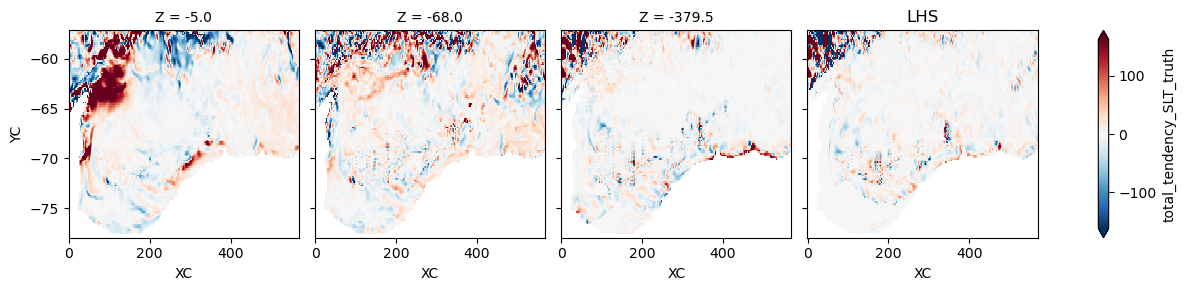

In [31]:
ds_sig_salt.total_tendency_SLT_truth.isel(time=200, Z=[0, 5, 15, 20]).where(mask).drop('XC').plot(robust=True, col='Z')
plt.title('LHS');

## Saving Data

- `drhodt` / `drhods`
- `ds_tmp_wg` / `ds_slt_wg` (rolled and wg slice)
- `ds_sig_theta` / `ds_sig_salt`

In [34]:
drhodts = xr.Dataset({'drhodt':(['time', 'Z', 'YC', 'XC'], drhodt.data), 
                      'drhods':(['time', 'Z', 'YC', 'XC'], drhods.data)}, 
                     coords=dict(time=ds_tmp_wg.time, Z=ds_tmp_wg.Z, YC=ds_tmp_wg.YC, XC=ds_tmp_wg.XC))

In [35]:
drhodts

,Array,Chunk
Bytes,9.77 GiB,22.83 MiB
Shape,"(438, 42, 125, 570)","(1, 42, 125, 570)"
Count,18 Graph Layers,438 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,9.77 GiB,22.83 MiB
Shape,"(438, 42, 125, 570)","(1, 42, 125, 570)"
Count,18 Graph Layers,438 Chunks
Type,float64,numpy.ndarray


In [40]:
ds_tmp_slt_wg = xr.merge([ds_tmp_wg, ds_slt_wg])

In [41]:
ds_tmp_slt_wg

,Array,Chunk
Bytes,4.88 GiB,11.42 MiB
Shape,"(438, 42, 125, 570)","(1, 42, 125, 570)"
Count,7 Graph Layers,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.88 GiB,11.42 MiB
Shape,"(438, 42, 125, 570)","(1, 42, 125, 570)"
Count,7 Graph Layers,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [44]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [45]:
#saving temperature component -> drho/dtheta * dtheta/dtime
gcsmap_sig_theta = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SOSE/ds_sig_theta_wg.zarr')
ds_sig_theta.to_zarr(gcsmap_sig_theta, mode='w')

In [46]:
#saving salt component -> drho/dsalt * dsalt/time
gcsmap_sig_salt = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SOSE/ds_sig_salt_wg.zarr')
ds_sig_salt.to_zarr(gcsmap_sig_salt, mode='w')

In [47]:
#saving drhodt and drhods
gcsmap_drhodts = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SOSE/drhodts_wg.zarr')
drhodts.to_zarr(gcsmap_drhodts, mode='w')

In [ ]:
#saving rolled ds_tmp_wg and ds_slt_wg
gcsmap_ds_tmp_slt_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SOSE/ds_tmp_slt_wg.zarr')
ds_tmp_slt_wg.to_zarr(gcsmap_ds_tmp_slt_wg, mode='w')

In [13]:
#saving rolled coords_wg
gcsmap_coords_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SOSE/coords_wg.zarr')
coords_wg.to_zarr(gcsmap_coords_wg, mode='w')